In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

from skimage.morphology import label
from skimage.io import imread
from numpy import expand_dims

import os
import time
import sys


Using TensorFlow backend.


In [2]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 45.10 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [3]:
from mrcnn.visualize import display_instances
from mrcnn.visualize import display_top_masks
from mrcnn.utils import extract_bboxes
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [5]:
marks1 = pd.read_csv('/spell/ship_segmentations.csv') # Markers for ships
marks1.reset_index(drop=True,inplace=True)
marks_unique = marks1[marks1.EncodedPixels.notnull()]

marks=marks_unique[1:100]
marks.reset_index(drop=True,inplace=True)
images =list(marks.ImageId)
marks.head()


,ImageId,EncodedPixels
0,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
1,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
2,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
3,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
4,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [6]:
test_marks=marks_unique[100:130]
test_marks.reset_index(drop=True,inplace=True)

test_images =list(test_marks.ImageId)
test_marks.head()

,ImageId,EncodedPixels
0,0056d301c.jpg,267626 6 268394 6 269162 6 269930 6 270698 6 2...
1,0056d301c.jpg,375395 3 376163 8 376931 12 377698 16 378466 1...
2,0056d301c.jpg,465211 2 465979 5 466746 8 467514 11 468282 14...
3,0056fbc62.jpg,378671 7 379439 7 380207 7 380975 7 381743 7 3...
4,00578738f.jpg,25178 11 25946 11 26714 11 27482 11 28250 11 2...


In [7]:
marks[2:3].EncodedPixels


2    55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
Name: EncodedPixels, dtype: object

In [8]:
TRAIN_DATA_PATH = '/spell/train'
TEST_DATA_PATH = '/spell/test'

IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)


In [9]:

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [10]:
class ShipDetection(Dataset):
    """Dataset class for training our dataset.
    """        
    # load the dataset definitions
    def load_dataset(self, images_list, marks_ann, dataset_dir,orig_height, orig_width):
         # Add classes
        self.add_class('ship', 1, 'Ship')
       # print(marks_ann)
        for i, fp in enumerate(images_list):            
            annotations=marks_ann.loc[marks_ann['ImageId'] == fp].EncodedPixels
            self.add_image('ship', image_id=i, path=os.path.join(dataset_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

    #Load Image
    def load_image(self, image_id):
        info=self.image_info[image_id]
        #print(info)
        image = imread(info['path'])
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    #Load Mask
    def load_mask(self, image_id):
        #print(self.image_info)
        info=self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a,SHAPE)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
# prepare train set
train_set = ShipDetection()
train_set.load_dataset(images,marks, TRAIN_DATA_PATH, IMAGE_HEIGHT,IMAGE_WIDTH)
train_set.prepare()




In [12]:
#Prepare test set
test_set = ShipDetection()
test_set.load_dataset(test_images,test_marks, TEST_DATA_PATH, IMAGE_HEIGHT,IMAGE_WIDTH)
test_set.prepare()

[1 1 1 1]


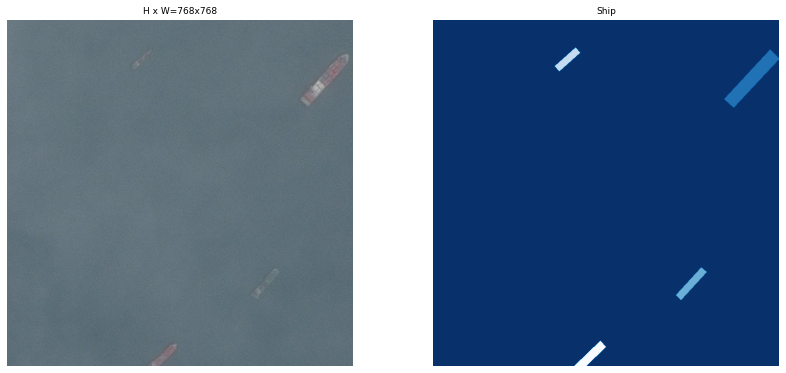

In [13]:
# Test code to check if image loading, masking and boxing works properly on not
# load an image
image_id = 40
image = train_set.load_image(image_id)
#plt.title("Actual")
#plt.imshow(image)


# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(class_ids)
# display image with masks and bounding boxes
#display_instances(image, bbox, mask, class_ids,  train_set.class_names,show_mask=True,show_bbox=True,title="Predicted",figsize=(8, 8))
display_top_masks(image, mask, class_ids, train_set.class_names, limit=1)

In [14]:
class AirbusConfig(Config):

    # Setting other parameters...

    def __init__(self, num_classes):
        self.NAME = "airbus_cfg"
        self.NUM_CLASSES = num_classes
        self.STEPS_PER_EPOCH =500
        self.IMAGE_MAX_DIM=IMAGE_WIDTH
        self.IMAGE_MIN_DIM=IMAGE_HEIGHT
        
        
        super().__init__()
        
config = AirbusConfig(num_classes=2)
config.NUM_CLASSES
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

molded_image             shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (768, 768, 1)         min:    0.00000  max:    1.00000  bool


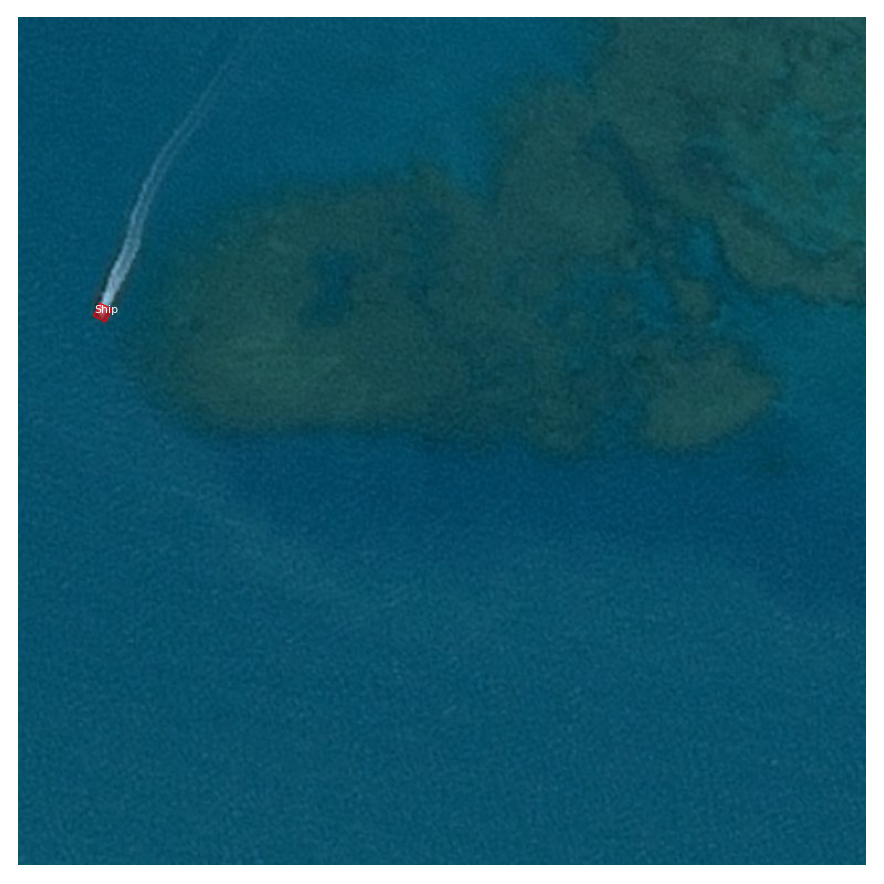

In [15]:
import mrcnn.model as modellib
from mrcnn.model import log
# Load and display using mrcnn model which is interally called all functions
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        train_set, config, image_id= 25, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names,
                            show_bbox=False,show_mask=True)

In [18]:
import warnings
warnings.filterwarnings("ignore")

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('/spell/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./airbus_cfg20200721T1926/mask_rcnn_airbus_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

In [19]:
# Code to get latest h5 file directory 
all_subdirs = [d for d in os.listdir('/spell/Mask_RCNN') if os.path.isdir(d)]
latest_subdir = max(all_subdirs, key=os.path.getmtime)
print(latest_subdir)

airbus_cfg20200721T1926


In [20]:
# Predict for test dataset
# define the prediction configuration
class PredictionConfig(Config):

    # Setting other parameters...

    def __init__(self, num_classes):
        self.NAME = "airbus_cfg"
        self.NUM_CLASSES = 2
        self.GPU_COUNT = 1
        self.IMAGES_PER_GPU = 1
        self.STEPS_PER_EPOCH=100
        self.IMAGE_MAX_DIM=IMAGE_WIDTH
        self.IMAGE_MIN_DIM=IMAGE_HEIGHT
        
        super().__init__()
        
config_pred = PredictionConfig(2)
config_pred.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [22]:
import warnings
warnings.filterwarnings("ignore")
# create config
config_pred = PredictionConfig(num_classes=2)
# define the model
model_eval = MaskRCNN(mode='inference', model_dir='./', config=config_pred)
# load model weights
model_eval.load_weights('/spell/Mask_RCNN/' + latest_subdir+ '/mask_rcnn_airbus_cfg_0002.h5', by_name=True)



Re-starting from epoch 2


In [23]:
def plot_actual_vs_predicted(dataset, model, cfg, image_id):
    # load image and mask 

    print(dataset.image_info[image_id]["path"])
    # load the image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    bbox = extract_bboxes(mask)  
    display_instances(image, bbox, mask,class_ids,dataset.class_names,title="Actual",figsize=(8, 8),show_mask=False)

    #Predicted image
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    # Visualize results
    r = yhat
    display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                       dataset.class_names, r['scores'],title="Predicted",figsize=(8, 8))


/spell/test/0056d301c.jpg


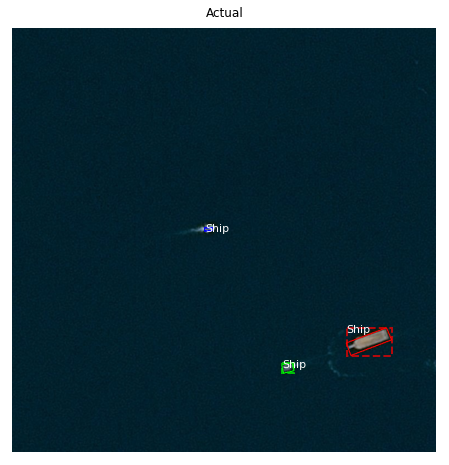

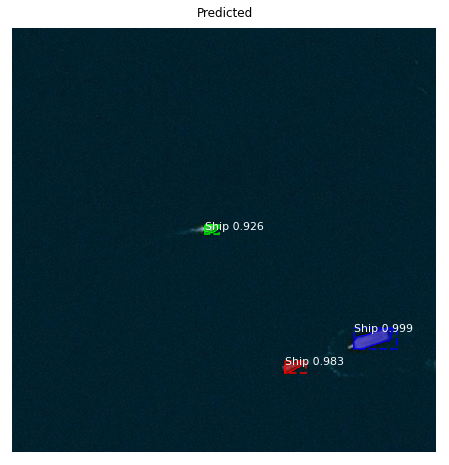

In [24]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model_eval, config_pred,  image_id=1)

# Detect new images

In [25]:

def detect_cells(path):
    # load image
    image = imread(path)
    
    plt.figure(figsize=(8,8))
    plt.title('Actual')
    plt.imshow(image)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, config_pred)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model_eval.detect(sample, verbose=0)[0]
    r = yhat
    print(r['class_ids'])
    print( r['scores'])
    display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                train_set.class_names, r['scores'],title="Predicted",figsize=(8,8),show_mask=True)


[1]
[0.9650796]


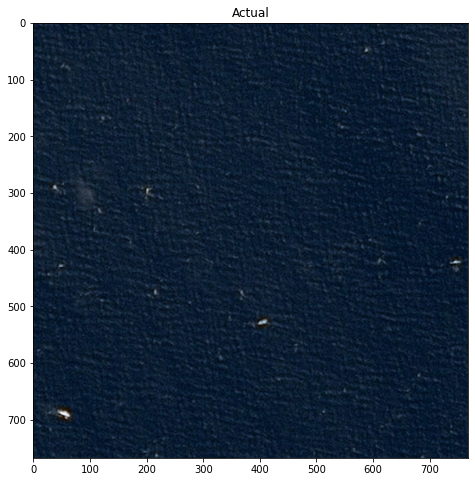

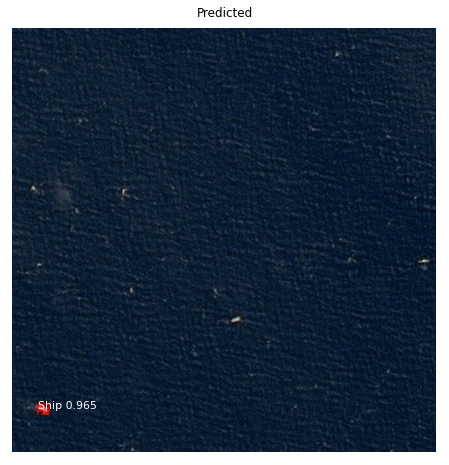

In [27]:
detect_cells("/spell/new/001eb2794.jpg")

[1]
[0.99659413]


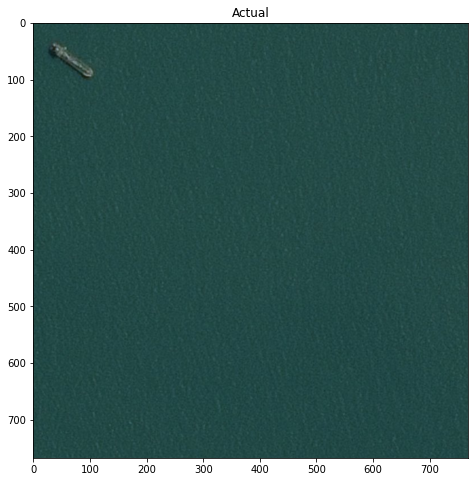

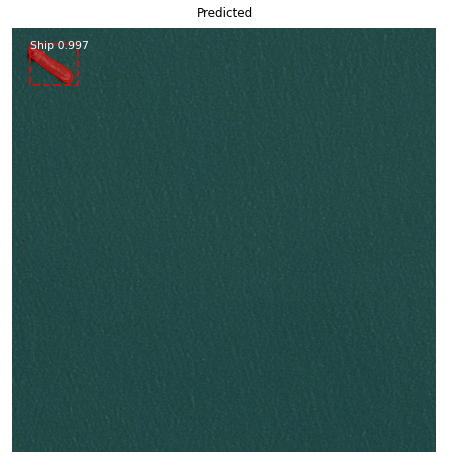

In [28]:
detect_cells("/spell/new/a97d55a5d.jpg")

[1]
[0.9916276]


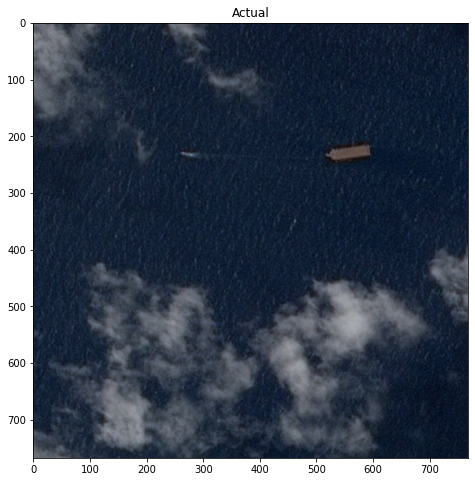

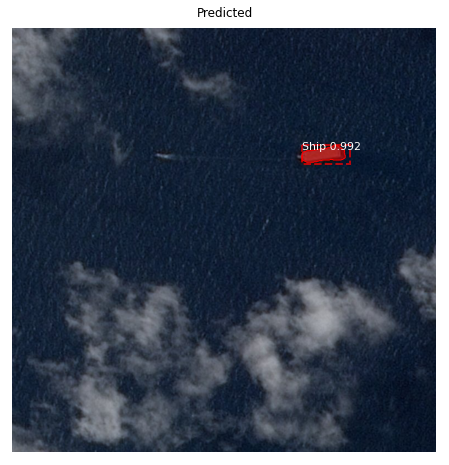

In [29]:
detect_cells("/spell/new/a9a01bb33.jpg")


In [30]:
!python --version

Python 3.7.8


[1 1 1 1 1 1 1 1]
[0.9990307  0.998456   0.9967836  0.9959008  0.9949602  0.9930782
 0.98428106 0.9670719 ]


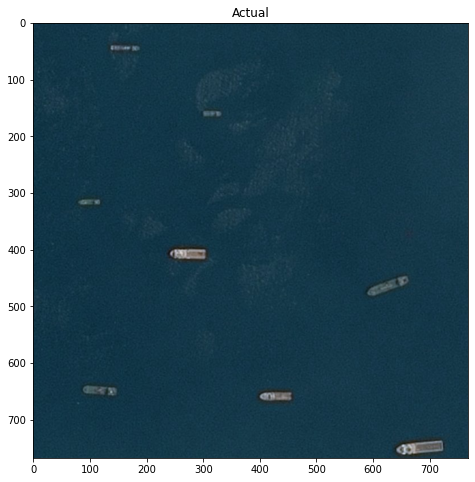

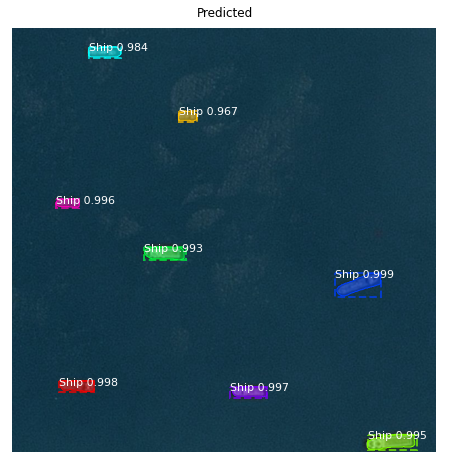

In [31]:
detect_cells("/spell/new/acb4aa56f.jpg")